In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import h5py
import os
import arviz as az
from scipy.stats import norm, halfnorm

ModuleNotFoundError: No module named 'seaborn'

In [2]:
project_dir = '/data/florican/jamiesonball/Intern_Project'

data_dir = os.path.join(project_dir, 'data')
data_filepath = os.path.join(data_dir, 'BGD_daily_inc_fatalities.h5')

data = pd.read_hdf(data_filepath,
                   key='event_data')

In [3]:
data['DATE'] =  pd.to_datetime(data['YEAR'].astype(int).astype(str) + data['DAY'].astype(int).astype(str), format='%Y%j')
data['MONTH'] = data['DATE'].dt.to_period ('M')
data['WEEK'] = data['DATE'].dt.to_period('W')

dhaka_battles = data.loc[data['ADM2_name'] == 'Dhaka'].loc[data['EVENT_TYPE'] == 'Battles'].groupby('WEEK', as_index=False)[['RAW_COUNTS', 'FATALITIES']].sum()
dhaka_battles['BOOLEAN_FATAL'] = dhaka_battles['FATALITIES'].astype('bool').astype('int')

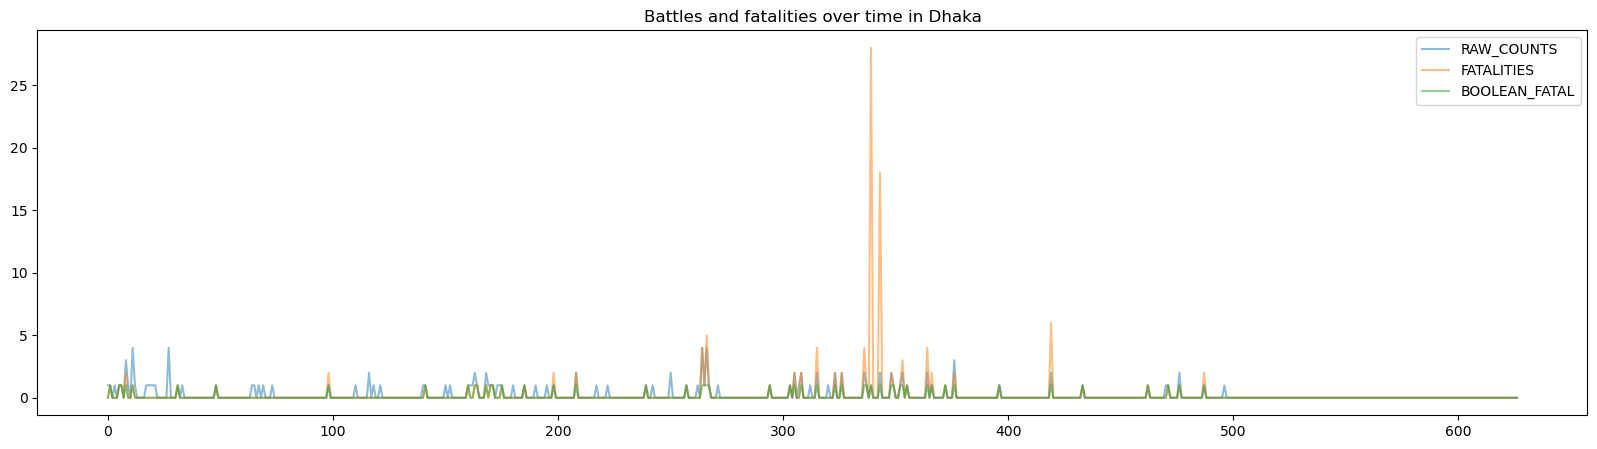

In [4]:
fig, ax = plt.subplots(figsize=(20,5))

dhaka_battles.plot(ax=ax, label='Fatalities', alpha=0.5) 

ax.set_title(f'Battles and fatalities over time in Dhaka')
ax.legend()
plt.show()

<Axes: xlabel='RAW_COUNTS', ylabel='BOOLEAN_FATAL'>

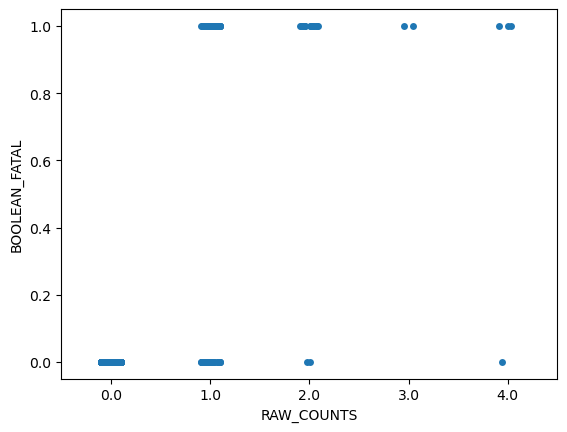

In [5]:
fig, ax = plt.subplots()

# ax.scatter(dhaka_battles['RAW_COUNTS'], dhaka_battles['BOOLEAN_FATAL'], alpha = 0.2)

sns.stripplot(x = 'RAW_COUNTS', y = 'BOOLEAN_FATAL', data = dhaka_battles)

In [6]:
dhaka_battles

,WEEK,RAW_COUNTS,FATALITIES,BOOLEAN_FATAL
0,2009-12-28/2010-01-03,1.0,0.0,0
1,2010-01-04/2010-01-10,1.0,1.0,1
2,2010-01-11/2010-01-17,0.0,0.0,0
3,2010-01-18/2010-01-24,1.0,0.0,0
4,2010-01-25/2010-01-31,0.0,0.0,0
...,...,...,...,...
622,2021-11-29/2021-12-05,0.0,0.0,0
623,2021-12-06/2021-12-12,0.0,0.0,0
624,2021-12-13/2021-12-19,0.0,0.0,0
625,2021-12-20/2021-12-26,0.0,0.0,0


In [7]:
fatalities = dhaka_battles['BOOLEAN_FATAL'].values
battle_counts = dhaka_battles['RAW_COUNTS'].values

v_alpha = 0.5
v_beta = 0.5

def log_prior_likelihood(alpha, beta, v_alpha, v_beta):
    '''
    Finds the prior likelihood for alpha and beta
    '''
    p_alpha = norm.logpdf(alpha, loc=0, scale=v_alpha)
    p_beta = norm.logpdf(beta, loc=0, scale=v_beta)
    return p_alpha+p_beta

def log_likelihood(fatalities, events, alpha, beta):
    likelihood_list = np.zeros(len(fatalities))
    for idx, event_count in enumerate(events):
        fatal = fatalities[idx]
        prob = inverse_logit(event_count, alpha, beta)
        likelihood_list[idx] = fatal*np.log(prob) + (1-fatal)*np.log(1-prob)
    return np.sum(likelihood_list)

def log_posterior_density(fatalities, events, alpha, beta, v_alpha, v_beta):
    log_prior = log_prior_likelihood(alpha, beta, v_alpha, v_beta)
    log_lik = log_likelihood(fatalities, events, alpha, beta)
    return log_prior+log_lik

def proposal_dist(alpha, beta, stepsize=0.5):
    return np.random.normal(alpha, stepsize), np.random.normal(beta, stepsize)

def proposal_alpha(alpha, stepsize = 0.5):
    return np.random.normal(alpha, stepsize)

def proposal_beta(beta, stepsize = 0.5):
    return np.random.normal(beta, stepsize)

def proposal_density_ratio(new_a, new_b, old_a, old_b, stepsize=0.5):
    forward_prob = norm.logpdf(new_a, loc=old_a, scale=stepsize) + norm.logpdf(new_b, loc=old_b, scale=stepsize)
    backward_prob = norm.logpdf(old_a, loc=new_a, scale=stepsize) + norm.logpdf(old_b, loc=new_b, scale=stepsize)
    return backward_prob-forward_prob

def inverse_logit(x, alpha, beta):
    return np.exp(alpha + x*beta)/(1+np.exp(alpha+x*beta))

def log_mh_mcmc(fatalities, events, initial_alpha, initial_beta, v_alpha, v_beta, target_dist, proposal_dist, sample_size=10000, burn_in=2000, stepsize = 0.5):
    '''
    Metropolis-Hastings algorithm implementation, using log likelihoods and densities
    
    Inputs:
    fatalities - numpy array of boolean fatality data
    events - numpy array of event counts
    initial alpha - initial alpha value to use
    initial beta - initial beta value to use
    v_alpha, v_beta - parameters for the prior
    target_dist - distribution to be estimated (posterior in implementation)
    proposal_dist - proposal distribution to sample from
    sample_size - length of chain to return, default 10000
    burn_in - length of chain to discard at beginning
    stepsize - parameter for the proposal distribution, corresponds to std.dev of normal

    Outputs:
    alpha_chain - chain of sampled alpha values
    beta_chain - chain of sampled beta values
    full_alpha_chain - all alpha values, including those rejected
    full_beta_chain - all beta values, including those rejected
    '''

    # set up the chains
    full_alpha_chain = [initial_alpha]
    full_beta_chain = [initial_beta]

    # initial variable setups
    proposal_counts = 0
    acceptance_count = 0
    current_alpha = initial_alpha
    current_beta = initial_beta

    # # burn-in section
    # for i in range(burn_in):
    #     # find the proposed values, add to full chain
    #     proposed_alpha, proposed_beta = proposal_dist(current_alpha, current_beta, stepsize)
    #     full_alpha_chain.append(proposed_alpha)
    #     full_beta_chain.append(proposed_beta)
    #     # reset the current parameter values
    #     current_alpha = proposed_alpha
    #     current_beta = proposed_beta

    # main chain section
    while len(full_alpha_chain) < sample_size + burn_in:
        # find proposed values
        proposed_alpha, proposed_beta = proposal_dist(current_alpha, current_beta, stepsize)

        # find the log likelihoods under the posterior for the current and proposed values
        log_post_current = target_dist(fatalities, events, current_alpha, current_beta, v_alpha, v_beta)
        log_post_proposed = target_dist(fatalities, events, proposed_alpha, proposed_beta, v_alpha, v_beta)
        density_ratio = proposal_density_ratio(proposed_alpha, proposed_beta, current_alpha, current_beta, stepsize)

        # calculate the acceptance ratio
        acceptance_ratio = log_post_proposed - log_post_current + density_ratio

        # # accept or reject the new sample accordingly
        # if acceptance_ratio > np.log(np.random.rand()):
        #     full_alpha_chain.append(proposed_alpha)
        #     full_beta_chain.append(proposed_beta)
        #     # update parameters
        #     current_alpha = proposed_alpha
        #     current_beta = proposed_beta
        #     # display progress notice
        #     if len(full_alpha_chain) % ((sample_size+burn_in)//10) == 0:
        #         print(f'{100*len(full_alpha_chain)/(sample_size+burn_in)}% complete')

        if acceptance_ratio > np.log(np.random.rand()):
            # record proposal
            full_alpha_chain.append(proposed_alpha)
            full_beta_chain.append(proposed_beta)
            # update current parameters
            current_alpha = proposed_alpha
            current_beta = proposed_beta
            acceptance_count += 1
        
        else:
            # otherwise record the same parameters
            full_alpha_chain.append(current_alpha)
            full_beta_chain.append(current_alpha)

        # update proposal counter
        proposal_counts += 1

    # calculate and display the acceptance rate
    acceptance_rate = acceptance_count/(sample_size + burn_in)
    print(f'Chain completed with sample acceptance rate of {round(acceptance_rate, 4)}')
    
    main_chain = pd.DataFrame({'ALPHA':full_alpha_chain[burn_in:], 'BETA':full_beta_chain[burn_in:]})
    full_chain = pd.DataFrame({'ALPHA':full_alpha_chain, 'BETA':full_beta_chain})

    # return the chains
    return main_chain, full_chain

def log_mh_mcmc_individual_update(fatalities, events, initial_alpha, initial_beta, v_alpha, v_beta,
                                  target_dist, alpha_proposal, beta_proposal, iterations=10000, alpha_stepsize=0.5, beta_stepsize=0.5):
    '''
    Metropolis-Hastings algorithm implementation, using log likelihoods and densities
    
    Inputs:
    fatalities - numpy array of boolean fatality data
    events - numpy array of event counts
    initial alpha - initial alpha value to use
    initial beta - initial beta value to use
    v_alpha, v_beta - parameters for the prior
    target_dist - distribution to be estimated (posterior in implementation)
    proposal_dist - proposal distribution to sample from
    sample_size - length of chain to return, default 10000
    burn_in - length of chain to discard at beginning
    stepsize - parameter for the proposal distribution, corresponds to std.dev of normal

    Outputs:
    alpha_chain - chain of sampled alpha values
    beta_chain - chain of sampled beta values
    full_alpha_chain - all alpha values, including those rejected
    full_beta_chain - all beta values, including those rejected
    '''

    # set up the chains
    alpha_chain = np.zeros(iterations+1)
    beta_chain = np.zeros(iterations+1)

    alpha_chain[0] = initial_alpha
    beta_chain[0] = initial_beta

    # initial variable setups
    alpha_acceptance_count = 0
    beta_acceptance_count = 0
    current_alpha = initial_alpha
    current_beta = initial_beta

    # # burn-in section
    # for i in range(burn_in):
    #     # find the proposed values, add to full chain
    #     proposed_alpha, proposed_beta = proposal_dist(current_alpha, current_beta, stepsize)
    #     full_alpha_chain.append(proposed_alpha)
    #     full_beta_chain.append(proposed_beta)
    #     # reset the current parameter values
    #     current_alpha = proposed_alpha
    #     current_beta = proposed_beta

    # main chain section
    for i in range(iterations):
        ###### ALPHA
        # propose alpha
        proposed_alpha = alpha_proposal(current_alpha, alpha_stepsize)

        # find the log likelihoods under the posterior for the current and proposed values
        log_post_current = target_dist(fatalities, events, current_alpha, current_beta, v_alpha, v_beta)
        log_post_proposed = target_dist(fatalities, events, proposed_alpha, current_beta, v_alpha, v_beta)

        # calculate the acceptance ratio
        acceptance_ratio = log_post_proposed - log_post_current
        if acceptance_ratio > np.log(np.random.rand()):
            # record proposal
            alpha_chain[i+1] = proposed_alpha
            # update current parameters
            current_alpha = proposed_alpha
            alpha_acceptance_count += 1
        
        else:
            # otherwise record the same parameters
            alpha_chain[i+1] = current_alpha

        ###### BETA
        # propose beta
        proposed_beta = beta_proposal(current_beta, beta_stepsize)

        # find the log likelihoods under the posterior for the current and proposed values
        log_post_current = target_dist(fatalities, events, current_alpha, current_beta, v_alpha, v_beta)
        log_post_proposed = target_dist(fatalities, events, current_alpha, proposed_beta, v_alpha, v_beta)

        # calculate the acceptance ratio
        acceptance_ratio = log_post_proposed - log_post_current
        if acceptance_ratio > np.log(np.random.rand()):
            # record proposal
            beta_chain[i+1] = proposed_beta
            # update current parameters
            current_beta = proposed_beta
            beta_acceptance_count += 1
        
        else:
            # otherwise record the same parameters
            beta_chain[i+1] = current_beta


    # calculate and display the acceptance rate
    alpha_acceptance_rate = alpha_acceptance_count/iterations
    beta_acceptance_rate = beta_acceptance_count/iterations
    print(f'Proposal acceptance rate of {alpha_acceptance_rate} for alpha')
    print(f'Proposal acceptance rate of {beta_acceptance_rate} for beta')
    
    chain = pd.DataFrame({'ALPHA':alpha_chain, 'BETA':beta_chain})

    # return the chains
    return chain

In [8]:
sample_size = 1000 # alter the sample size

initial_alpha, initial_beta = 0.0, 0.0 # alter the initial sample
v_alpha, v_beta = 1.0, 1.0 # alter the priors
alpha_stepsize, beta_stepsize = 0.4, 0.4

#main_chain, full_chain = log_mh_mcmc(fatalities, battle_counts, initial_alpha, initial_beta, v_alpha, v_beta, log_posterior_density, proposal_dist, stepsize = 0.5, sample_size = sample_size)

full_chain = log_mh_mcmc_individual_update(fatalities, battle_counts, initial_alpha, initial_beta, v_alpha, v_beta,
                                           log_posterior_density, proposal_alpha, proposal_beta, iterations=sample_size,
                                           alpha_stepsize=alpha_stepsize, beta_stepsize=beta_stepsize)

main_chain = full_chain.iloc[round(sample_size/2):].reset_index()

Proposal acceptance rate of 0.471 for alpha
Proposal acceptance rate of 0.498 for beta


In [9]:
from dhaka_battles_functions import *

def proposal_alpha(alpha, stepsize = 0.5):
    return np.random.normal(alpha, stepsize)

def proposal_beta(beta, stepsize = 0.5):
    return np.random.normal(beta, stepsize)

parameter_names = ['ALPHA', 'BETA']
initial_params = [0.0, 0.0]
param_steps = [0.4, 0.4]
param_prior_params = [1.0, 1.0]
proposal_dists = [proposal_alpha, proposal_beta]
iterations = 10000

full_chain = general_mh_mcmc(fatalities, battle_counts,
                             parameter_names, initial_params, param_steps, param_prior_params, proposal_dists,
                             target_dist = log_posterior_density, iterations=iterations)

main_chain = full_chain.iloc[round(iterations/2):].reset_index()

alpha_ess = az.ess(main_chain['ALPHA'].values)
beta_ess = az.ess(main_chain['BETA'].values)

print(f'The effective sample size for alpha is {alpha_ess}')
print(f'The effective sample size for beta  is {beta_ess}')

Proposal acceptance rate of 0.4801 for parameter ALPHA
Proposal acceptance rate of 0.5283 for parameter BETA
The effective sample size for alpha is 304.6963783017942
The effective sample size for beta  is 290.68516609825497


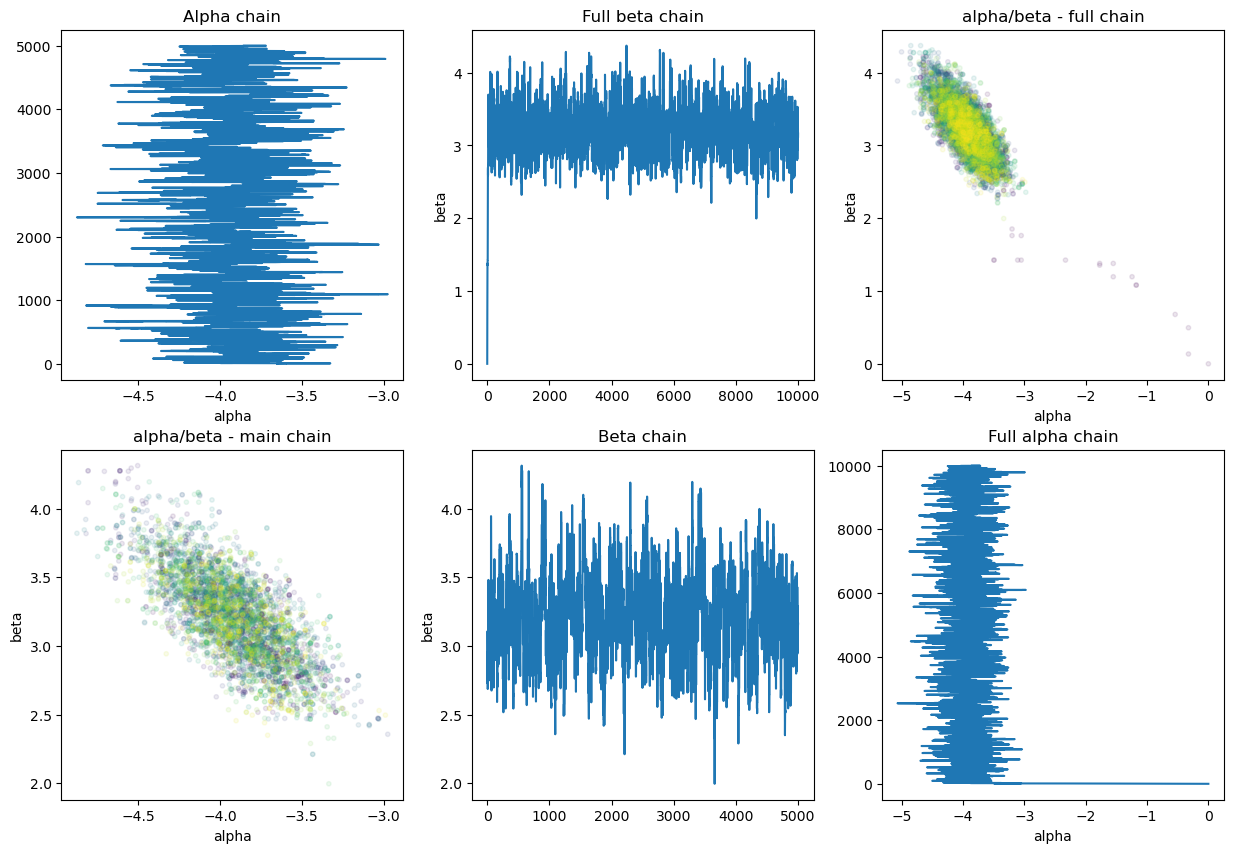

In [10]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

ax[0,0].plot(main_chain['ALPHA'], range(len(main_chain['ALPHA'])))
ax[0,0].set(title = 'Alpha chain',
            xlabel = 'alpha')

ax[0,1].plot(full_chain['BETA'])
ax[0,1].set(title = 'Full beta chain',
            ylabel = 'beta')

ax[0,2].scatter('ALPHA', 'BETA', s=10, c=range(len(full_chain['ALPHA'])), alpha=0.1, data=full_chain)
ax[0,2].set(title = 'alpha/beta - full chain',
            xlabel = 'alpha',
            ylabel = 'beta')

ax[1,0].scatter('ALPHA', 'BETA', s=10, c=range(len(main_chain['ALPHA'])), alpha=0.1, data=main_chain)
ax[1,0].set(title = 'alpha/beta - main chain',
            xlabel = 'alpha',
            ylabel = 'beta')

ax[1,1].plot(main_chain['BETA'])
ax[1,1].set(title = 'Beta chain',
            ylabel = 'beta')

ax[1,2].plot(full_chain['ALPHA'], range(len(full_chain['ALPHA'])))
ax[1,2].set(title = 'Full alpha chain',
            xlabel = 'alpha')

plt.show()

In [11]:
def posterior_centile(num, alpha, beta, centiles=[0.25], mean=False):
    sorted_values = np.sort(inverse_logit(num, alpha, beta))
    sample_size = len(alpha)
    results = np.zeros(len(centiles))
    if mean == True:
        return np.mean(sorted_values)
    else:
        for (idx, centile) in enumerate(centiles):
            position = round(sample_size * centile)
            results[idx] = sorted_values[position]
        return results

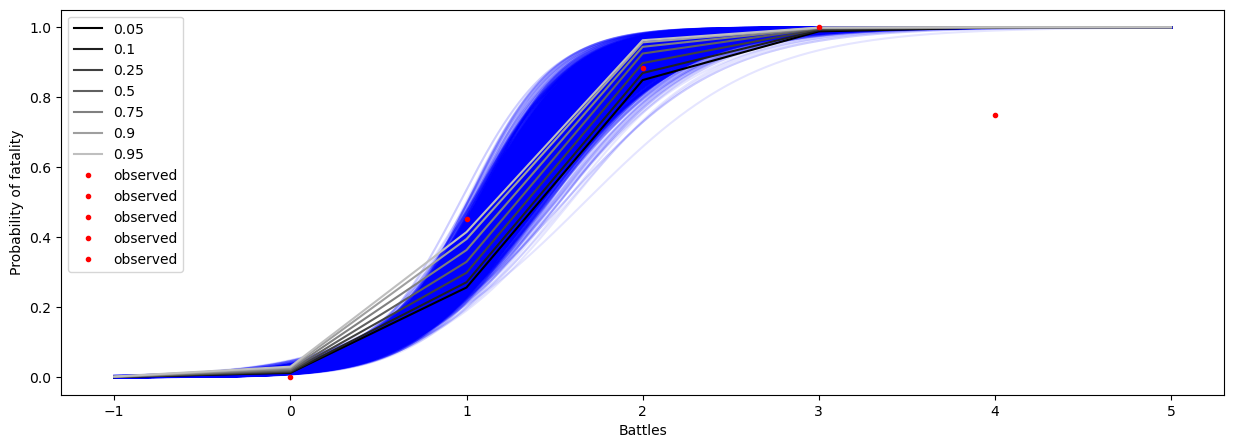

In [12]:
fig, ax = plt.subplots(figsize = (15, 5))

x_axis = np.linspace(-1, 5, 1000)
event_counts = np.linspace(-1, 5, 7)

centiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
centiles_collated = pd.DataFrame({'centiles':centiles})

for i, alpha in enumerate(main_chain['ALPHA']):
    beta = main_chain['BETA'][i]
    probs = inverse_logit(x_axis, alpha, beta)
    ax.plot(x_axis, probs, c='b', alpha=0.1)

for i in range(-1, 6):
    centiles_collated[f'{i}'] = posterior_centile(i, main_chain['ALPHA'].values, main_chain['BETA'].values, centiles)

for idx, centile in enumerate(centiles):
    ax.plot(event_counts, centiles_collated.loc[centiles_collated['centiles'] == centile].transpose().values[1:], c=(2*idx/16, 2*idx/16, 2*idx/16), label=f'{centile}')

for i in range(5):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    ax.plot(i, fatal/total, 'r.', label='observed')

#probs = np.exp(alpha_mean + beta_mean*x_axis)/(1+np.exp(alpha_mean + beta_mean*x_axis))

#ax.plot(x_axis, probs, c='red')

ax.set(xlabel='Battles',
       ylabel='Probability of fatality')

ax.legend(loc = 'best')

plt.show()

In [13]:
for i in range(5):
    mean = posterior_centile(i, main_chain['ALPHA'], main_chain['BETA'], mean=True)
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    print(f'The posterior mean proportion of weeks with {i} battles that have a fatality is {round(mean, 3)} compared to observed {round(fatal/total, 3)}')

The posterior mean proportion of weeks with 0 battles that have a fatality is 0.02 compared to observed 0.0
The posterior mean proportion of weeks with 1 battles that have a fatality is 0.332 compared to observed 0.451
The posterior mean proportion of weeks with 2 battles that have a fatality is 0.918 compared to observed 0.882
The posterior mean proportion of weeks with 3 battles that have a fatality is 0.996 compared to observed 1.0
The posterior mean proportion of weeks with 4 battles that have a fatality is 1.0 compared to observed 0.75


The effective sample size for alpha is 304.6963783017942
The effective sample size for beta  is 290.68516609825497


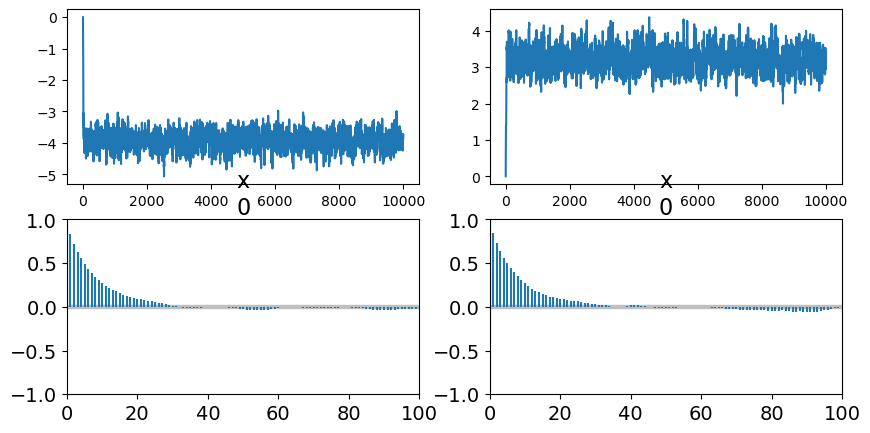

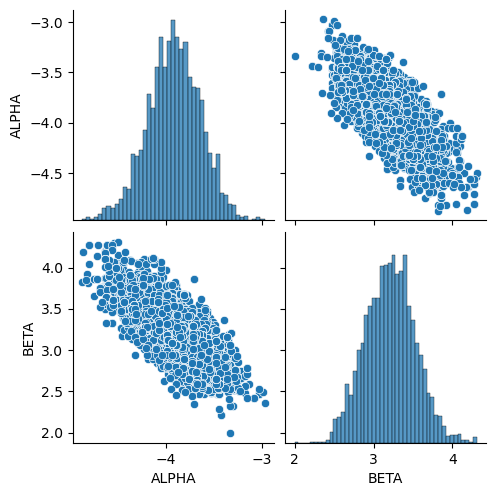

In [14]:
# MCMC diagnostics

alpha_ess = az.ess(main_chain['ALPHA'].values)
beta_ess = az.ess(main_chain['BETA'].values)

print(f'The effective sample size for alpha is {alpha_ess}')
print(f'The effective sample size for beta  is {beta_ess}')

fig, ax = plt.subplots(2,2, figsize=(10, 5))

ax[0,0].plot(full_chain['ALPHA'])
ax[0,1].plot(full_chain['BETA'])

az.plot_autocorr(full_chain['ALPHA'].values, ax=ax[1,0])
az.plot_autocorr(full_chain['BETA'].values, ax=ax[1,1])

sns.pairplot(main_chain.iloc[:, 1:])
plt.show()